### References:
- End-to-end classifier of irregular time series: https://arxiv.org/pdf/1606.04443.pdf
- Kernels for extrapolation: http://proceedings.mlr.press/v28/wilson13.pdf
- Multioutput spectral kernel: https://arxiv.org/pdf/1709.01298.pdf

### TODO:
- Implement MOGP kernel for multiband time series
- Test recurrent NN
- Test AMSgrad: https://github.com/taki0112/AMSGrad-Tensorflow
- Inspect variational GP: https://arxiv.org/pdf/1711.10127.pdf

In [1]:
#https://danijar.com/structuring-your-tensorflow-models/
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import tensorflow as tf
import time

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


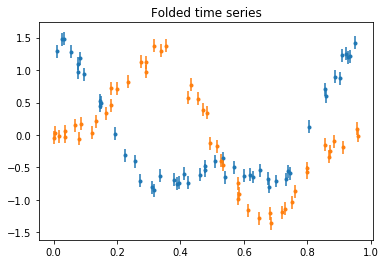

In [2]:
# Mock data to test
N = 50
s_noise = 0.1
t = np.linspace(0.0, 10.0, num=N)
t1 = t + 0.1*(10/N)*np.random.randn(N)
t1 = np.sort(t1)
v1_clean = np.cos(2.0*np.pi*t1) + 0.5*np.cos(4.0*np.pi*t1) 
v1 = v1_clean + s_noise*np.random.randn(N)
t2 = t + 0.1*(10/N)*np.random.randn(N)
t2 = np.sort(t2)
v2_clean = np.sin(2.0*np.pi*t2) - 0.5*np.sin(4.0*np.pi*t2) 
v2 = v2_clean + s_noise*np.random.randn(N)
plt.errorbar(np.mod(t1,1), v1, s_noise, fmt='.')
plt.errorbar(np.mod(t2,1), v2, s_noise, fmt='.')
plt.title("Folded time series");

In [4]:
# Parameters
n_mc_samples = 32
n_pivots = 100
n_neuron_conv = 8
n_neuron_fc = 64
n_classes = 2 

#tf.set_random_seed(0)
tf.reset_default_graph()
T = tf.placeholder(dtype=tf.float32, shape=(None), name='signal_time')
V = tf.placeholder(dtype=tf.float32, shape=(None), name='signal_value')
E = tf.placeholder(dtype=tf.float32, shape=(None), name='signal_error')
P = tf.placeholder(dtype=tf.float32, shape=(), name='signal_period')
Y = tf.placeholder(dtype=tf.float32, shape=(n_classes), name='signal_label')
lc_nsamples = tf.cast(tf.shape(T)[0], tf.int32, name='signal_nsamples')

with tf.variable_scope('gp_kernel_layer'):
    # TODO: Make param per class, make x_tf variable
    x_tf = tf.expand_dims(tf.linspace(0.0, 10.0, num=n_pivots), axis=[0], name="inducing_points") 
    # These have to be non-negative
    gp_logvar_likelihood = tf.Variable(tf.random_normal([1], mean=0.0, stddev=0.1, dtype=tf.float32), 
                                       name='logvar_likelihood')
    gp_logvar_kernel = tf.Variable(tf.random_normal([1], mean=0.0, stddev=0.1, dtype=tf.float32), 
                                   name='logvar_kernel')
    gp_logtau_kernel = tf.Variable(tf.random_normal([1], mean=0.0, stddev=0.1, dtype=tf.float32), 
                                   name='logtau_kernel')
    def periodic_kernel(X1, X2):
        return tf.exp(gp_logvar_kernel)*tf.exp(-tf.square(tf.sin(P*np.pi*(tf.transpose(X1) - X2)))*tf.exp(gp_logtau_kernel))
    
    
    T_mat = tf.reshape(T, shape=(1, -1))    
    gp_kernel_periodic_tx = periodic_kernel(T_mat, x_tf) 
    gp_kernel_periodic_tt = periodic_kernel(T_mat, T_mat)  + tf.exp(gp_logvar_likelihood)*tf.eye(lc_nsamples) + tf.diag(E**2)
    gp_kernel_periodic_xx = periodic_kernel(x_tf, x_tf)

# Exact computation of the GP posterior, not using fast sampling techniques
with tf.variable_scope('gp_posterior_layer'):
    Ltt =  torch.potrf(gp_kernel_periodic_tt, upper=False)
    tmp1 = tf.matrix_triangular_solve(Ltt, gp_kernel_periodic_tx, lower=True)
    tmp2 = tf.matrix_triangular_solve(Ltt, tf.expand_dims(V, axis=[1]))
    mu = tf.transpose(tf.matmul(tmp1, tmp2, transpose_a=True), name='posterior_mean')
    S = gp_kernel_periodic_xx - tf.matmul(tmp1, tmp1, transpose_a=True, name='posterior_covariance') 

# Reparametrization trick x ~ N(mu, S) <=> x = mu + eL, e ~ N(0, I), S = RRt
with tf.variable_scope('sampling_layer'):
    R = tf.cholesky(S + 1e-5*tf.eye(n_pivots))
    # L, V = np.linalg.eigh(S)
    # R = np.dot(np.dot(V, np.diag(np.sqrt(L + 1e-15))), V.T)
    eps = tf.random_normal([n_mc_samples, n_pivots])
    nn_input = tf.add(mu, tf.matmul(eps, R, transpose_b=True))
# This makes the network invariant to translation
# TODO: how many filters?, how big? how many layers?
with tf.variable_scope('conv1d_layer'):
    layer_out = tf.layers.conv1d(tf.expand_dims(nn_input, axis=[1]), filters=n_neuron_conv, activation=tf.nn.relu, 
                                 data_format='channels_first', use_bias=True, strides=1, kernel_size=3, padding='SAME')
    layer_out = tf.layers.max_pooling1d(layer_out, pool_size=2, strides=2,
                                data_format='channels_first', padding='SAME')
    #layer_out = tf.nn.conv1d(nn_input, W, stride=1, padding='SAME', 
    #                         use_cudnn_on_gpu=True, data_format='NCW', name='conv_operation')

# Simple MLP architecture on top
with tf.variable_scope('fc_layer'):
    layer_out = tf.layers.flatten(layer_out)
    n_neuron_input = int(n_pivots*n_neuron_conv/2)
    W = tf.Variable(tf.random_normal([n_neuron_input, n_neuron_fc], dtype=tf.float32), name='weights')
    b = tf.Variable(tf.random_normal([n_neuron_fc], dtype=tf.float32), name='bias')
    layer_out = tf.nn.relu(tf.add(tf.matmul(layer_out, W), b))

with tf.variable_scope('output_layer'):
    W = tf.Variable(tf.random_normal([n_neuron_fc, n_classes], dtype=tf.float32), name='weights')
    b = tf.Variable(tf.random_normal([n_classes], dtype=tf.float32), name='bias')
    logits = tf.add(tf.matmul(layer_out, W), b)
    prediction = tf.nn.softmax(logits, name='prediction')

with tf.variable_scope('train_ops'):
    ext_labels = tf.tile(tf.reshape(Y, shape=(1, -1)), multiples=(n_mc_samples, 1))
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=ext_labels))
    #optimizer = tf.train.AdamOptimizer(learning_rate=1e-3, epsilon=1e-6)
    optimizer = tf.train.MomentumOptimizer(learning_rate=1e-4, momentum=0.75, use_nesterov=True)
    # TODO: Try AMSgrad
    train_op = optimizer.minimize(loss_op)

# Summaries for tensorboard
with tf.variable_scope('summaries'):
    summary_loss = tf.summary.scalar("loss_train", loss_op)
    summary_sk = tf.summary.scalar("sigma_kernel", tf.reduce_sum(tf.exp(0.5*gp_logvar_kernel)))
    summary_sl = tf.summary.scalar("sigma_likelihood", tf.reduce_sum(tf.exp(0.5*gp_logvar_likelihood)))
    summary_tk = tf.summary.scalar("tau_kernel", tf.reduce_sum(tf.exp(0.5*gp_logtau_kernel)))
    merged_summaries = tf.summary.merge([summary_loss, summary_sl, summary_sk, summary_tk], name='summary_train')

init = tf.global_variables_initializer()
print("DONE")

DONE


In [ ]:
%%time
training_epochs = 200

with tf.Session() as sess:
    tf_writer = tf.summary.FileWriter("/tmp/tensorboard/gp_adapter_MLP_"+str(time.time()), sess.graph)
    sess.run(init)
    for k in range(training_epochs):
        ans1 = sess.run([nn_input, mu, R, train_op],
                       feed_dict={T: t1.astype(np.float32), 
                                  V: v1.astype(np.float32), E: 0.1*np.ones(shape=(len(t1),)).astype(np.float32),
                                  P: 1.0, Y: [1.0, 0.0]}
                      )
        ans2 = sess.run([nn_input, mu, R, merged_summaries, train_op],
                       feed_dict={T: t2.astype(np.float32), 
                                  V: v2.astype(np.float32), E: 0.1*np.ones(shape=(len(t1),)).astype(np.float32),
                                  P: 1.0, Y: [0.0, 1.0]}
                      )
        tf_writer.add_summary(ans2[3], global_step=k)
        tf_writer.flush()

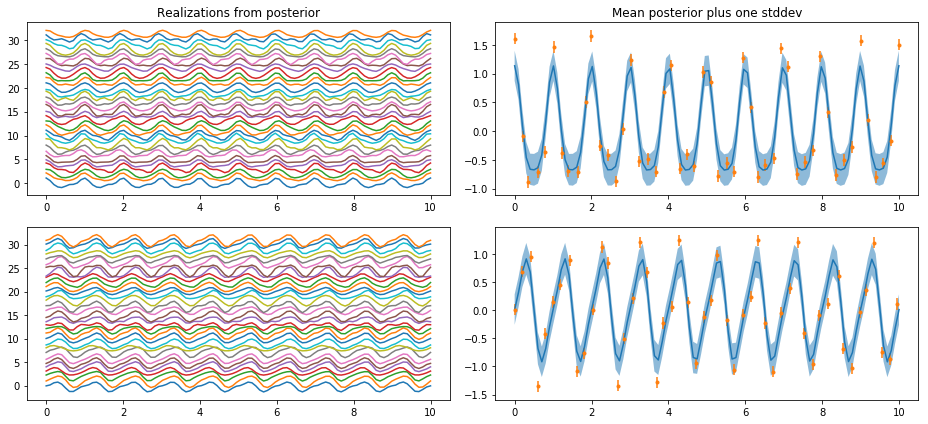

In [88]:
x = np.linspace(0.0, 10.0, num=n_pivots)
fig = plt.figure(figsize=(13, 6))
ax = fig.add_subplot(2, 2, 1)
ax.set_title('Realizations from posterior')
for i in range(32):
    ax.plot(x, i+ans1[0][i, :])
ax = fig.add_subplot(2, 2, 2)
ax.set_title('Mean posterior plus one stddev')    
ax.plot(x, ans1[1][0, :])
ax.fill_between(x, ans1[1][0, :] - np.sqrt(np.sum(ans1[2]**2, axis=1)), 
                ans1[1][0, :] + np.sqrt(np.sum(ans1[2]**2, axis=1)), alpha=0.5)
ax.errorbar(t1, v1, s_noise, fmt='.')

ax = fig.add_subplot(2, 2, 3)
for i in range(32):
    ax.plot(x, i+ans2[0][i, :])
    
ax = fig.add_subplot(2, 2, 4)
ax.plot(x, ans2[1][0, :])
ax.fill_between(x, ans2[1][0, :] - np.sqrt(np.sum(ans2[2]**2, axis=1)), 
                ans2[1][0, :] + np.sqrt(np.sum(ans2[2]**2, axis=1)), alpha=0.5)
ax.errorbar(t2, v2, s_noise, fmt='.')
#ax.plot(t2, v2_clean, '-')
plt.tight_layout();